In [334]:
import numpy as np

from dreamcoder.domains.quantum_algorithms.primitives import *
from dreamcoder.domains.quantum_algorithms.tasks import *
import dreamcoder as dc

import time
from tqdm import trange

In [335]:

n_qubit = 2
full_circuit = [n_qubit,
           [["cnot", 0, 1],
           ["swap", 0, 1],
           ["hadamard", 1]]
]

In [336]:
tensor = eye(n_qubit)
tensor_to_mat(swap(cnot(tensor,0,1),0,1))

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]], dtype=float16)

In [4]:
full_circuit_to_mat(full_circuit)

array([[ 0.707,  0.707,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.707,  0.707],
       [ 0.   ,  0.   ,  0.707, -0.707],
       [ 0.707, -0.707,  0.   ,  0.   ]], dtype=float16)

In [5]:
print_circuit(full_circuit)

                  
q_0: ──■───X──────
     ┌─┴─┐ │ ┌───┐
q_1: ┤ X ├─X─┤ H ├
     └───┘   └───┘


In [6]:
with QiskitTester(full_circuit) as QT:
    QT.circuit.cnot(QT.q(0),QT.q(1))
    QT.circuit.swap(QT.q(0),QT.q(1))
    QT.circuit.h(QT.q(1))
print(QT)
QT.check()

     ┌───┐   ┌───┐
q_0: ┤ X ├─X─┤ H ├
     └─┬─┘ │ └───┘
q_1: ──■───X──────
                  


Code consistent with Qiskit


In [7]:
n_qubit= 3
code = dc.program.Program.parse("(lambda (cnot (minv(mv(no_op $0)))))")
code.infer()
code.evaluate([])(n_qubit)


[[1, -1, 3], [['cnot', 1, 0]]]

In [8]:
state_circuit_to_mat(code.evaluate([])(n_qubit))

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float16)

In [9]:
tasks = makeTasks()

In [220]:
task = get_task_from_name("hadamard_0",tasks)
code = dc.program.Program.parse("(lambda (h (no_op $0)))")
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(0.0, -3.8918202981106265)

In [11]:
task =get_task_from_name("cnot_01",tasks)
code = dc.program.Program.parse("(lambda (cnot (no_op $0)))")
task.logLikelihood(code), grammar.logLikelihood(code.infer(), code)

(0.0, -3.8918202981106265)

In [12]:
task = get_task_from_name("cnot_10",tasks)
code = dc.program.Program.parse("(lambda (cnot (minv(mv(no_op $0)))))")
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(0.0, -7.783640596221253)

In [13]:
task = get_task_from_name("swap_01",tasks)
code = dc.program.Program.parse("(lambda  (cnot(minv(mv_r(cnot(minv (mv (cnot (no_op $0)))))))))")
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(0.0, -15.567281192442506)

In [14]:
task = get_task_from_name("cz_01",tasks)
code = dc.program.Program.parse("(lambda (h(mv(cnot(mv_r(h (mv (no_op $0))))))))")
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)
np.round(state_circuit_to_mat(code.evaluate([])(2)),decimals=2)

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0., -1.]], dtype=float16)

In [15]:
with QiskitTester(code.evaluate([])(3)) as QT:
    QT.circuit.cz(QT.q(0),QT.q(1))
print(QT)
QT.check()
np.real(np.array(QT.result))

        
q_0: ───
        
q_1: ─■─
      │ 
q_2: ─■─
        


Code consistent with Qiskit


array([[ 1.,  0.,  0.,  0.,  0.,  0., -0., -0.],
       [ 0.,  1.,  0.,  0.,  0.,  0., -0., -0.],
       [ 0.,  0.,  1.,  0.,  0.,  0., -0., -0.],
       [ 0.,  0.,  0.,  1.,  0.,  0., -0., -0.],
       [ 0.,  0.,  0.,  0.,  1.,  0., -0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -0., -1.]])

In [16]:
with QiskitTester(code.evaluate([])(2)) as QT:
    QT.circuit.cz(QT.q(1),QT.q(0))
print(QT)
np.real(np.array(QT.result))

        
q_0: ─■─
      │ 
q_1: ─■─
        


array([[ 1.,  0.,  0., -0.],
       [ 0.,  1.,  0., -0.],
       [ 0.,  0.,  1., -0.],
       [ 0.,  0.,  0., -1.]])

In [17]:
task = get_task_from_name("cnot_nn_1",tasks)
code = dc.program.Program.parse("(lambda (cnot ((rep (dec(dec(size_to_int $0))) (lambda (mv $0))) (no_op $0))))")
code.evaluate([])(3)
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(0.0, -14.155496613885283)

In [18]:
task = get_task_from_name("swap_0n",tasks)
code = dc.program.Program.parse("(lambda ((  (rep (dec(dec(size_to_int $0))) (lambda ((cnot(minv(mv_r(cnot(minv (mv (cnot(mv_r $0)))))))))) )  (mv_r( (rep (dec(size_to_int $0)) (lambda (mv((cnot(minv(mv_r(cnot(minv (mv (cnot $0)))))))))) ) (no_op $0) )))))")
print_circuit(code.evaluate([])(3))
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)

          ┌───┐                         ┌───┐     
q_0: ──■──┤ X ├──■───────────────────■──┤ X ├──■──
     ┌─┴─┐└─┬─┘┌─┴─┐     ┌───┐     ┌─┴─┐└─┬─┘┌─┴─┐
q_1: ┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├
     └───┘     └───┘┌─┴─┐└─┬─┘┌─┴─┐└───┘     └───┘
q_2: ───────────────┤ X ├──■──┤ X ├───────────────
                    └───┘     └───┘               


(0.0, -52.145060152057745)

In [ ]:
task = get_task_from_name("swap_0n",tasks)
code = dc.program.Program.parse("(lambda ((  (rep (dec(dec(size_to_int $0))) (lambda (swap(mv_r $0))) )  (mv_r( (rep (dec(size_to_int $0)) (lambda (mv(swap $0))) ) (no_op $0) )))))")
print_circuit(code.evaluate([])(5))
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)

In [ ]:
task = get_task_from_name("swap_0n",tasks)
code = dc.program.Program.parse("(lambda ((  (rep (dec(dec(size_to_int $0))) (lambda (swap(mv_r $0))) )  (mv_r( (rep (dec(size_to_int $0)) (lambda (mv(swap $0))) ) (no_op $0) )))))")
print_circuit(code.evaluate([])(5))
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)

In [32]:
code.evaluate([])(5)

[[0, 1, 5],
 [['swap', 0, 1],
  ['swap', 1, 2],
  ['swap', 2, 3],
  ['swap', 3, 4],
  ['swap', 2, 3],
  ['swap', 1, 2]]]

In [19]:
%load_ext line_profiler

In [18]:
try:
    import binutil  # required to import from dreamcoder modules
except ModuleNotFoundError:
    import bin.binutil  # alt import if called as module

from dreamcoder.domains.quantum_algorithms.main import main
from dreamcoder.dreamcoder import commandlineArguments
from dreamcoder.utilities import numberOfCPUs

arguments = commandlineArguments(
    featureExtractor=None, # it was TowerCNN
    CPUs=numberOfCPUs(),
    helmholtzRatio=0.5,
    recognitionTimeout=3600,
    iterations=6,
    a=3,
    structurePenalty=1,
    pseudoCounts=10,
    topK=2,
    maximumFrontier=5,
    extras=None,
    solver="python", 
    useRecognitionModel=False,
    enumerationTimeout=500,#-g
    compressor="pypy")   #ocaml, python, pypy  
%lprun -f dc.domains.quantum_algorithms.tasks.QuantumTask.logLikelihood main(arguments)

CUDA is available?: False
using cuda?: False


/Users/lsarra/opt/anaconda3/envs/dc/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Users/lsarra/opt/anaconda3/envs/dc/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html

*** KeyboardInterrupt exception caught in code being profiled.

Timer unit: 1e-06 s

Total time: 17.6378 s
File: /Users/lsarra/ownCloud/topics/artificial-scientific-discovery/2021_Unitary-Synthesis/ec/dreamcoder/domains/quantum_algorithms/tasks.py
Function: logLikelihood at line 21

Line #      Hits         Time  Per Hit   % Time  Line Contents
    21                                               def logLikelihood(self, e, timeout=None):
    22    912398     552896.0      0.6      3.1          if QuantumTask.last_algorithm is not e:
    23     57970      67900.0      1.2      0.4              QuantumTask.last_algorithm = e
    24     57970      59239.0      1.0      0.3              QuantumTask.last_algorithm_evaluations = {}
    25                                           
    26    914625     803899.0      0.9      4.6          for n in range(self.min_size, self.max_size):
    27    914568     616811.0      0.7      3.5              if n not in QuantumTask.last_algorithm_evaluations.keys():
    28     60140    9599297.0    159.6     54.4        

In [10]:
code = dc.program.Program.parse("(lambda ((rep (dec(dec(dec 0))) (lambda (mv $0))) (no_op $0)))")
code.evaluate([])(3)
code.infer()
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


Exception: Invalid repetition number.

## Recognition model

In [17]:
#continuationtype = tcircuit
#avoid  no _ op 

In [10]:
restricted_pcfg = dc.grammar.PCFG.from_grammar(grammar, request=dc.type.arrow(tsize, tcircuit))
full_pcfg = dc.grammar.PCFG.from_grammar(full_grammar, request=dc.type.arrow(tsize, tcircuit))


In [11]:
def enumerate_grammar(grammar, timeout, circuit_execution_function): #circuit execution function either full_circuit_to_mat or state_circuit_to_mat
    pcfg =  dc.grammar.PCFG.from_grammar(grammar, request=dc.type.arrow(tsize, tcircuit))
    enum_dictionary = {}
    t_0 = time.time()
    for i in pcfg.quantized_enumeration():
        if (time.time()>t_0+timeout): break
    
        code = dc.program.Program.parse(str(i))
        
        # check if it is a valid circuit
        try:
            circuit = code.evaluate([])(3)
            unitary = circuit_execution_function(circuit)
            enum_dictionary[str(unitary)]={"task":str(code), "circuit_3":circuit, "time": time.time()-t_0}
        except QuantumCircuitException:
            ...
    eprint(f"Enumerated {len(enum_dictionary)} programs")
    return enum_dictionary

In [227]:
restricted_dictionary = enumerate_grammar(grammar,timeout=600, circuit_execution_function=state_circuit_to_mat)
full_dictionary = enumerate_grammar(full_grammar,timeout=600, circuit_execution_function=full_circuit_to_mat)

[(lambda (mv (mv 0))), (lambda (h 0)), (lambda (mv (mv_r 0))), (lambda (cnot 0)), (lambda (mv (minv 0))), (lambda (rep 2 (lambda 3) 0)), (lambda (mv (no_op 1))), (lambda (mv (h 0))), (lambda (mv (cnot 0))), (lambda (mv (rep 2 (lambda 3) 0))), (lambda (mv_r 0)), (lambda (minv 0)), (lambda (no_op 1))]
Enumerated 1604 programs
[(lambda (fh (fno_op 1) 2)), (lambda (fh (fh 0 2) 2)), (lambda (fh (fcnot 0 2 2) 2)), (lambda (fh (fswap 0 2 2) 2)), (lambda (fh 0 0)), (lambda (fh 0 (inc 2))), (lambda (fh 0 (dec 2))), (lambda (fh 0 (size_to_int 1))), (lambda (fcnot 0 2 2)), (lambda (fswap 0 2 2))]
Enumerated 584 programs


In [228]:
matched_programs = []
for unitary in full_dictionary.keys():
    if unitary in restricted_dictionary.keys():
        try:
            full_task = full_dictionary[unitary]["task"]
            full_unitary = full_circuit_to_mat(dc.program.Program.parse(full_task).evaluate([])(4))
            
            restricted_task = restricted_dictionary[unitary]["task"]
            restricted_unitary = state_circuit_to_mat(dc.program.Program.parse(restricted_task).evaluate([])(4))

            if np.all(full_unitary==restricted_unitary):
                matched_programs.append([full_task, 
                                         restricted_task, 
                                         max(full_dictionary[unitary]["time"],restricted_dictionary[unitary]["time"])])
        except QuantumCircuitException:
            ...
eprint(f"Enumerated {len(matched_programs)} programs")
# how long it took to enumerate (when the program was found)

Enumerated 75 programs


In [229]:
import pickle
import os
save_path = os.path.join("experimentOutputs/quantum/","matched_programs")

In [230]:
with open(save_path,"wb") as f:
    pickle.dump(matched_programs, f)

In [13]:
with open(save_path,"rb") as f:
        matched_programs = pickle.load(f)

In [ ]:
dc.program.Program.parse(matched_programs[0][0]).evaluate([])(3)

[3, [['hadamard', 1], ['swap', 1, 0], ['swap', 1, 0]]]

In [384]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence

class BagOfWordsFeatureExtractor(nn.Module):
    def __init__(self, tasks, full_op_names): # why do we need tasks?
        super(BagOfWordsFeatureExtractor, self).__init__()
        self.recomputeTasks = False
        
        self.qubit_test_range = [3,5]
        self.qubit_num = self.qubit_test_range[1]-self.qubit_test_range[0]+1
        
        self.names = list(full_op_names.keys())
        self.len_names =len(self.names)
        
        self.outputDimensionality = self.len_names*self.qubit_num
        self.tasks=tasks
        
    # full_circuit to embedding (bag of words)
    def full_circuit_to_embedding(self, full_circuit):
        embedding = np.zeros([self.len_names], dtype=int)
        for operation in full_circuit:
            embedding[self.names.index(operation[0])]+=1
        return embedding

    def full_task_to_embedding(self,full_task):
        full_embedding = np.hstack(
            [self.full_circuit_to_embedding(full_task.target_algorithm(n_qubit)[1]) 
             for n_qubit in range(self.qubit_test_range[0],self.qubit_test_range[1]+1)]
            )
        return full_embedding
    
    def featuresOfTask(self, t):
        return dc.recognition.variable(self.full_task_to_embedding(t)).float()
    def featuresOfTasks(self, ts):
        return dc.recognition.variable([self.full_task_to_embedding(t) for t in ts]).float()
    
    def taskOfProgram(self, p, t): # why do we need this?
        return dc.task.Task("dummy task", t, [])

In [411]:
feature_extractor = BagOfWordsFeatureExtractor(None, full_op_names)
recognition_model = dc.recognition.RecognitionModel(feature_extractor, grammar)
lr=0.000001
optimizer = torch.optim.Adam(recognition_model.parameters(), lr=lr, eps=1e-3, amsgrad=True)
losses = []

In [428]:
for _ in trange(200):
    for matched_program in matched_programs:
        i = np.random.randint(0, len(matched_programs))
        task = QuantumTask("generated_task", lambda n_qubit:dc.program.Program.parse(matched_programs[i][0]).evaluate([])(n_qubit))
        embedding = recognition_model.featureExtractor.featuresOfTask(task)
        
        simple_program = dc.program.Program.parse(matched_programs[i][1])
        summary = grammar.closedLikelihoodSummary(simple_program.infer(),simple_program)

        optimizer.zero_grad()
        recognition_model.zero_grad()
        
        feature = recognition_model._MLP(embedding)
        features = feature.expand(1, feature.size(-1))
        lls = recognition_model.grammarBuilder.batchedLogLikelihoods(features, [summary])
        loss = -lls.max()
        
        loss.backward()
        optimizer.step()
        losses.append(loss.data.item())

100%|██████████| 200/200 [01:09<00:00,  2.89it/s]


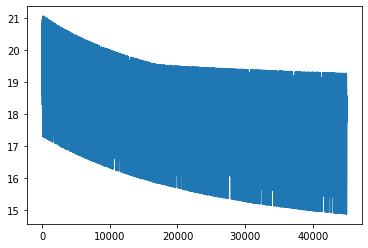

In [429]:
plt.plot(losses)

In [430]:
recognition_model.grammarBuilder.logProductions(feature)

tensor([ 0.1368, -0.5481, -0.0259, -0.4185,  0.4409,  0.4034, -0.9387, -1.0949,
         0.4342, -0.3485,  0.6718,  0.5667], grad_fn=<AddBackward0>)

In [431]:
task = get_task_from_name("cnot_10",tasks)
code = dc.program.Program.parse("(lambda (cnot (minv(mv(no_op $0)))))")

embedding = recognition_model.featureExtractor.featuresOfTask(task)
predicted_grammar_of_task = recognition_model(embedding)

grammar.logLikelihood(code.infer(),code), predicted_grammar_of_task.logLikelihood(code.infer(),code)

(-7.783640596221253, tensor([-7.4376], grad_fn=<SubBackward0>))

In [432]:
task = get_task_from_name("swap_01",tasks)
code = dc.program.Program.parse("(lambda  (cnot(minv(mv_r(cnot(minv (mv (cnot (no_op $0)))))))))")

embedding = recognition_model.featureExtractor.featuresOfTask(task)
predicted_grammar_of_task = recognition_model(embedding)

grammar.logLikelihood(code.infer(),code), predicted_grammar_of_task.logLikelihood(code.infer(),code)

(-15.567281192442506, tensor([-14.8134], grad_fn=<SubBackward0>))

In [433]:
task = get_task_from_name("swap_0n",tasks)
code = dc.program.Program.parse("(lambda ((  (rep (dec(dec(size_to_int $0))) (lambda ((cnot(minv(mv_r(cnot(minv (mv (cnot(mv_r $0)))))))))) )  (mv_r( (rep (dec(size_to_int $0)) (lambda (mv((cnot(minv(mv_r(cnot(minv (mv (cnot $0)))))))))) ) (no_op $0) )))))")

embedding = recognition_model.featureExtractor.featuresOfTask(task)
predicted_grammar_of_task = recognition_model(embedding)

grammar.logLikelihood(code.infer(),code), predicted_grammar_of_task.logLikelihood(code.infer(),code)

(-52.145060152057745, tensor([-50.6194], grad_fn=<SubBackward0>))

In [366]:

# profile running time, enumeration speed

In [ ]:
# def train_quantum(matched_dictionary={unitaries: simple_program, complicated_list},)
# for each sample
#     embedding= feature_extractor([unitary, complicated_list]) (i.e. encoder)  #in the case of great we first need an embedding and here we get the final embedding
    
#     # apply the recognition model
#     [from frontierBiasOptimal]
#     features = self._MLP(features)
#     features = features.expand(batchSize, features.size(-1))  # TODO
#     lls = self.grammarBuilder.batchedLogLikelihoods(features, [simple_program])
        
#     # train (optimize -lls  adam)
#     lls.backward
    
# # look at the new likelihoods
#     recognitionmodel.grammarOfTask

In [ ]:
# get more enumerated tasks (10k)

# bags of words (Gates) e.g. number of occurrences for each gate
# great https://github.com/google-research/crossbeam/blob/main/crossbeam/model/great.py
